In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')


In [81]:
df = pd.read_csv('/content/train.csv')
df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [82]:
df.shape


(800, 22)

In [83]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [84]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
ID,800.0,400.500000,231.084400,1.000000,200.750000,400.500000,600.250000,800.000000
A1_Score,800.0,0.560000,0.496697,0.000000,0.000000,1.000000,1.000000,1.000000
A2_Score,800.0,0.530000,0.499411,0.000000,0.000000,1.000000,1.000000,1.000000
A3_Score,800.0,0.450000,0.497805,0.000000,0.000000,0.000000,1.000000,1.000000
A4_Score,800.0,0.415000,0.493030,0.000000,0.000000,0.000000,1.000000,1.000000
A5_Score,800.0,0.395000,0.489157,0.000000,0.000000,0.000000,1.000000,1.000000
A6_Score,800.0,0.303750,0.460164,0.000000,0.000000,0.000000,1.000000,1.000000
A7_Score,800.0,0.397500,0.489687,0.000000,0.000000,0.000000,1.000000,1.000000
A8_Score,800.0,0.508750,0.500236,0.000000,0.000000,1.000000,1.000000,1.000000
A9_Score,800.0,0.495000,0.500288,0.000000,0.000000,0.000000,1.000000,1.000000


Data Cleaning

In [85]:
df['ethnicity'].value_counts()


,count
ethnicity,
White-European,257
?,203
Middle Eastern,97
Asian,67
Black,47
South Asian,34
Pasifika,32
Others,29
Latino,17


In [86]:
df['relation'].value_counts()


,count
relation,
Self,709
?,40
Parent,29
Relative,18
Others,2
Health care professional,2


In [87]:
df = df.replace({'yes':1, 'no':0, '?':'Others', 'others':'Others'})


Exploratory Data Analysis

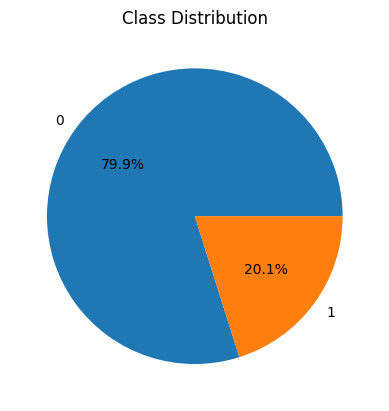

In [88]:
# Plot class distribution
plt.pie(df['Class/ASD'].value_counts().values, labels=df['Class/ASD'].value_counts().index, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()


In [89]:
# Separate columns by type
ints = [col for col in df.columns if df[col].dtype == int]
objects = [col for col in df.columns if df[col].dtype == object]
floats = [col for col in df.columns if df[col].dtype == float]


In [90]:
# Remove non-numeric and target columns from ints
ints.remove('ID')
ints.remove('Class/ASD')

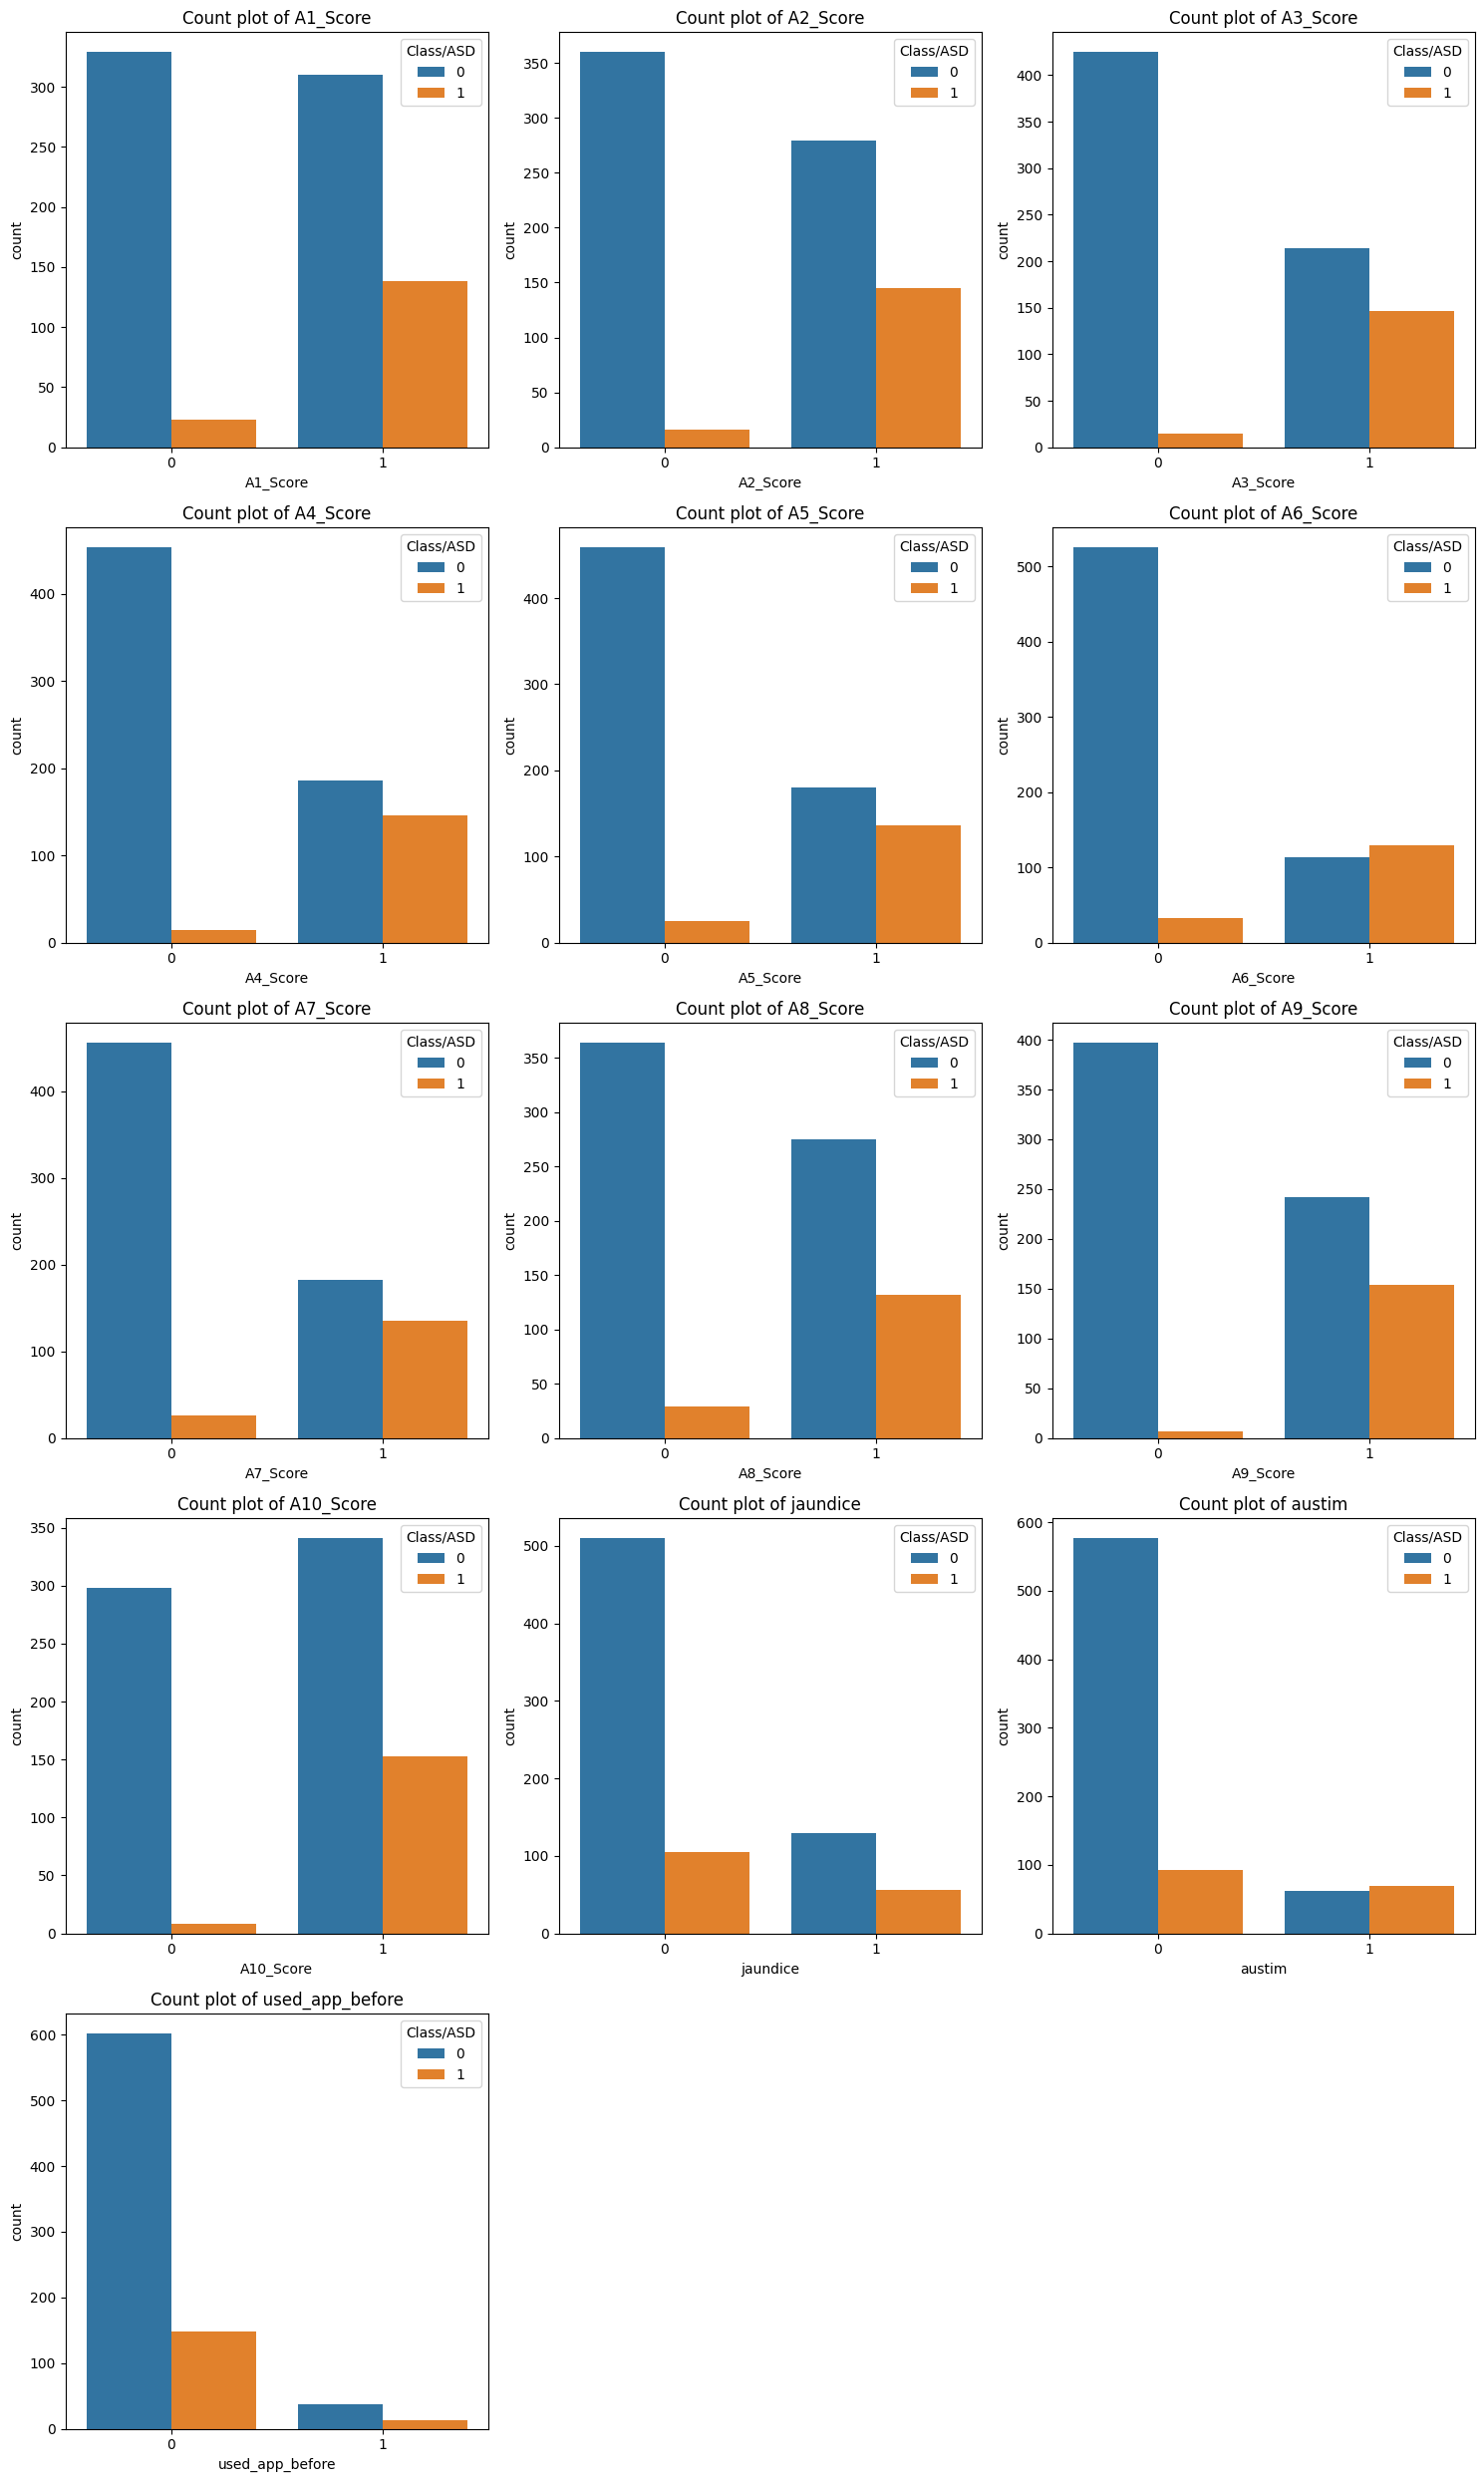

In [92]:
# Count plots for integer features
n_ints = len(ints)
ncols_ints = 3
nrows_ints = (n_ints // ncols_ints) + (n_ints % ncols_ints > 0)

plt.subplots(figsize=(15, 5 * nrows_ints))
for i, col in enumerate(ints):
    plt.subplot(nrows_ints, ncols_ints, i + 1)
    sb.countplot(data=df, x=col, hue='Class/ASD')
    plt.title(f'Count plot of {col}')
plt.tight_layout()
plt.show()

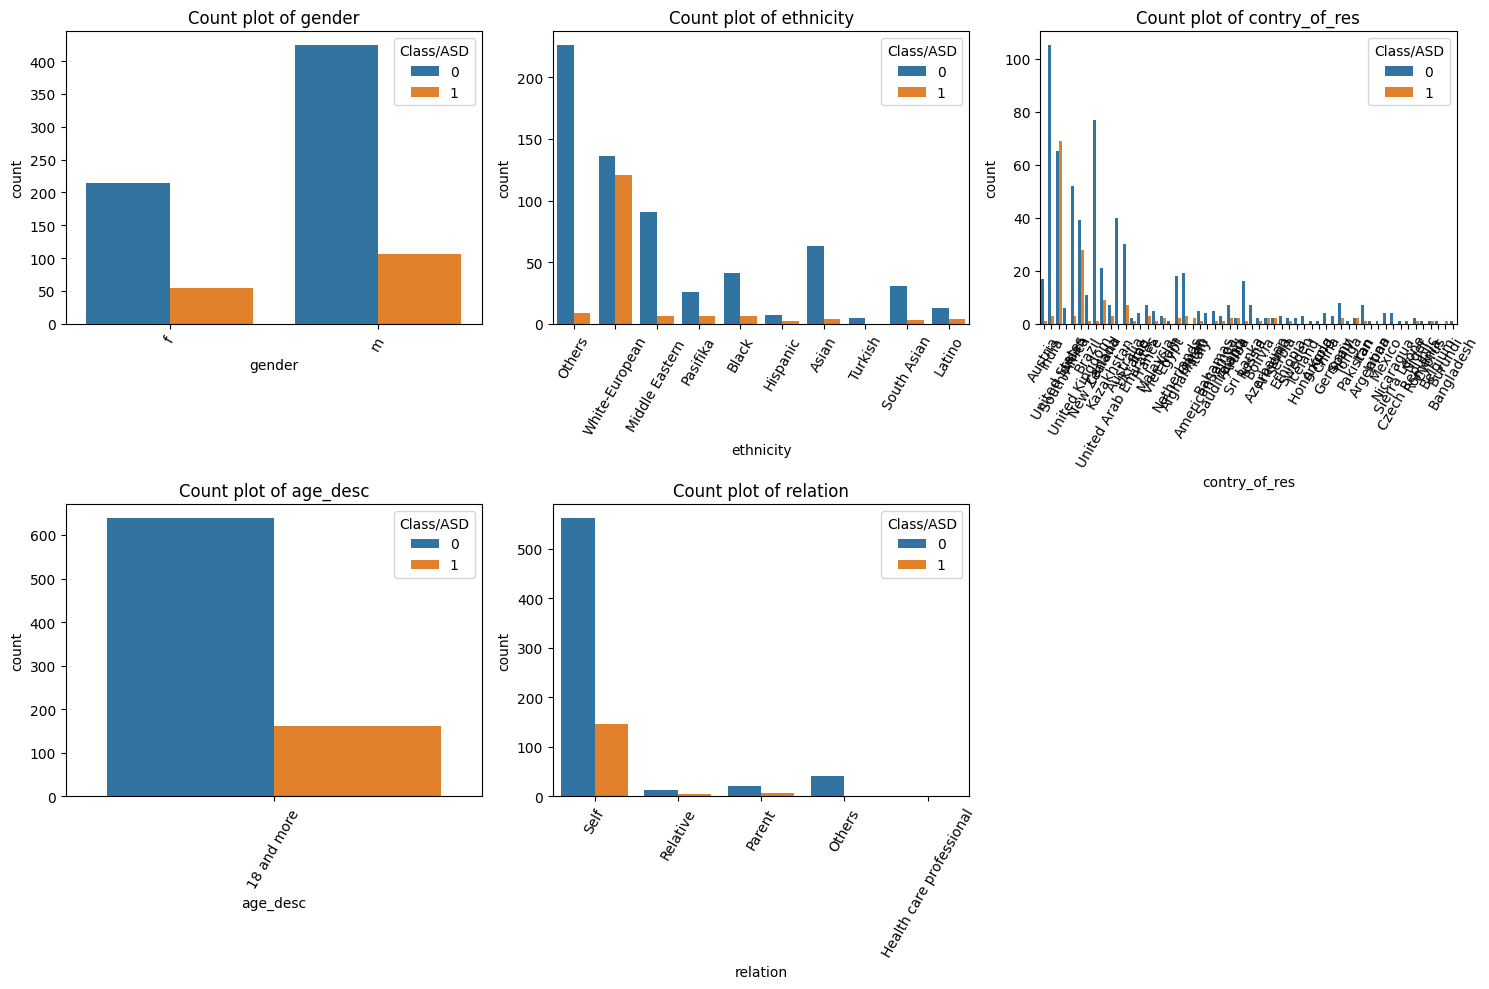

In [93]:
# Count plots for object features
n_objects = len(objects)
ncols_objects = 3
nrows_objects = (n_objects // ncols_objects) + (n_objects % ncols_objects > 0)

plt.subplots(figsize=(15, 5 * nrows_objects))
for i, col in enumerate(objects):
    plt.subplot(nrows_objects, ncols_objects, i + 1)
    sb.countplot(data=df, x=col, hue='Class/ASD')
    plt.xticks(rotation=60)
    plt.title(f'Count plot of {col}')
plt.tight_layout()
plt.show()

In [95]:
# Check the column names in the DataFrame
print(df.columns)

# Verify that 'country_of_res' is present and check unique values
if 'country_of_res' in df.columns:
    print(df['country_of_res'].unique())
else:
    print("Column 'country_of_res' not found in the DataFrame")

# Proceed with plotting if the column exists
if 'country_of_res' in df.columns:
    plt.figure(figsize=(15, 5))
    sb.countplot(data=df, x='country_of_res', hue='Class/ASD')
    plt.xticks(rotation=90)
    plt.title('Count plot of country_of_res')
    plt.show()
else:
    print("Cannot plot count plot as 'country_of_res' is not present in the DataFrame")


Index(['ID', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score',
       'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age',
       'gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res',
       'used_app_before', 'result', 'age_desc', 'relation', 'Class/ASD'],
      dtype='object')
Column 'country_of_res' not found in the DataFrame
Cannot plot count plot as 'country_of_res' is not present in the DataFrame


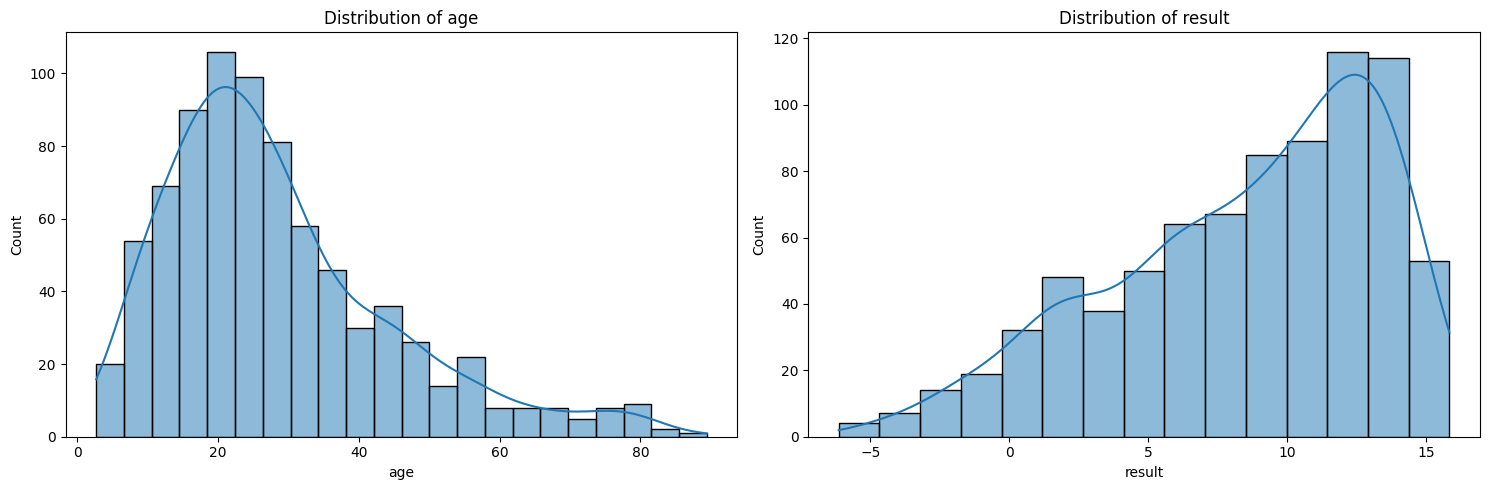

In [97]:
# Distribution and box plots for float features
n_floats = len(floats)
ncols_floats = 2
nrows_floats = (n_floats // ncols_floats) + (n_floats % ncols_floats > 0)

plt.subplots(figsize=(15, 5 * nrows_floats))
for i, col in enumerate(floats):
    plt.subplot(nrows_floats, ncols_floats, i + 1)
    sb.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


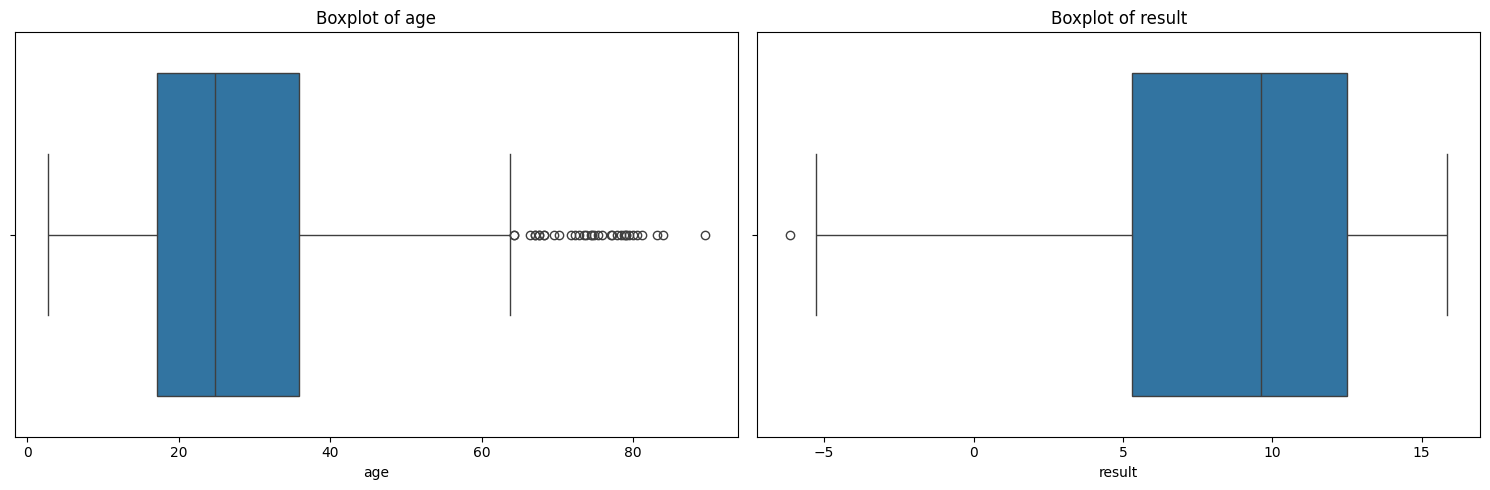

In [98]:
plt.subplots(figsize=(15, 5 * nrows_floats))
for i, col in enumerate(floats):
    plt.subplot(nrows_floats, ncols_floats, i + 1)
    sb.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


In [99]:
# Filter out extreme values
df = df[df['result'] > -5]
print(df.shape)

(798, 22)


In [100]:
# Convert age to age groups
def convertAge(age):
    if age < 4:
        return 'Toddler'
    elif age < 12:
        return 'Kid'
    elif age < 18:
        return 'Teenager'
    elif age < 40:
        return 'Young'
    else:
        return 'Senior'

df['ageGroup'] = df['age'].apply(convertAge)


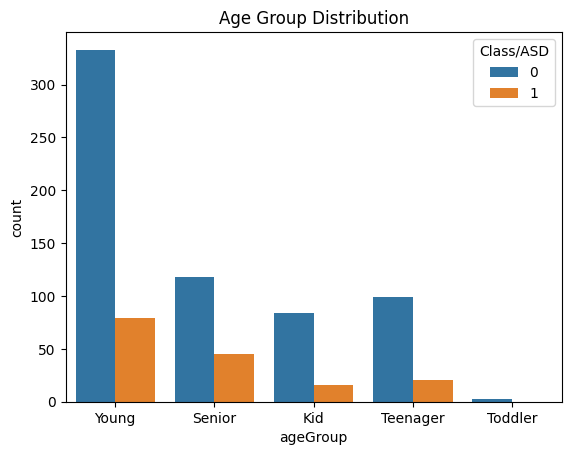

In [101]:
# Plot age group distribution
sb.countplot(x=df['ageGroup'], hue=df['Class/ASD'])
plt.title('Age Group Distribution')
plt.show()

In [102]:
# Feature engineering
def add_feature(data):
    data['sum_score'] = data.loc[:, 'A1_Score':'A10_Score'].sum(axis=1)
    data['ind'] = data['austim'] + data['used_app_before'] + data['jaundice']
    return data

df = add_feature(df)

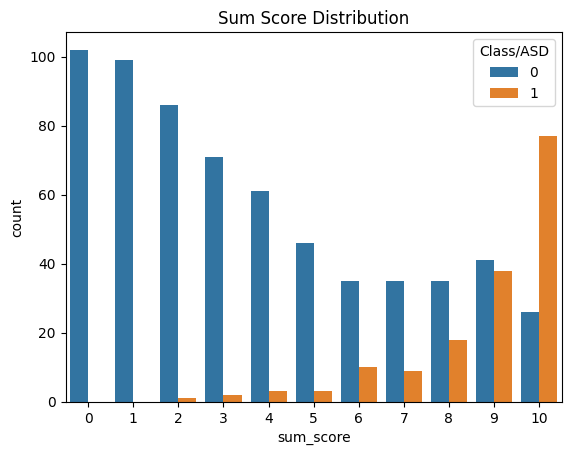

In [103]:
# Plot sum_score distribution
sb.countplot(x=df['sum_score'], hue=df['Class/ASD'])
plt.title('Sum Score Distribution')
plt.show()

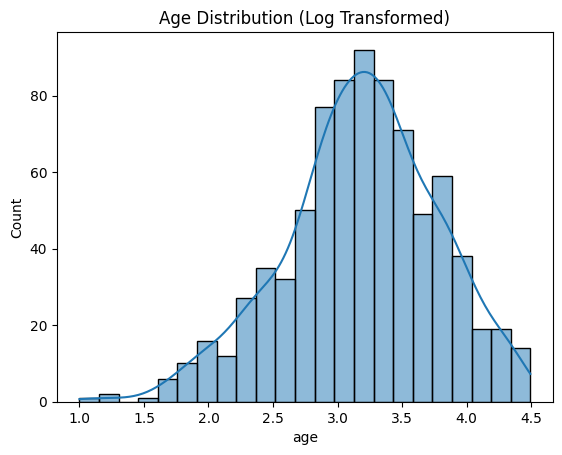

In [104]:
# Log transformation of age
df['age'] = df['age'].apply(lambda x: np.log(x))

# Plot age distribution after log transformation
sb.histplot(df['age'], kde=True)
plt.title('Age Distribution (Log Transformed)')
plt.show()


In [105]:
# Label encoding for categorical features
def encode_labels(data):
    for col in data.columns:
        if data[col].dtype == 'object':
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
    return data

df = encode_labels(df)

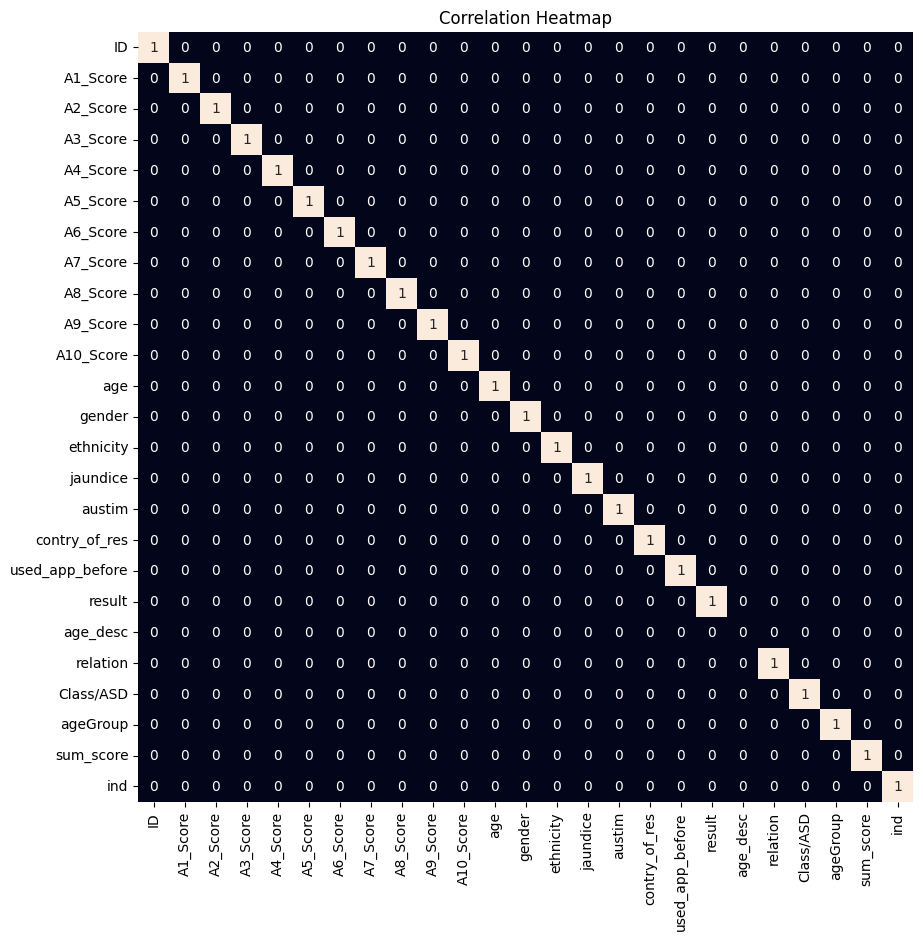

In [106]:
# Heatmap for correlation matrix
plt.figure(figsize=(10,10))
sb.heatmap(df.corr() > 0.8, annot=True, cbar=False)
plt.title('Correlation Heatmap')
plt.show()

In [107]:
# Prepare features and target
removal = ['ID', 'age_desc', 'used_app_before', 'austim']
features = df.drop(removal + ['Class/ASD'], axis=1)
target = df['Class/ASD']

In [108]:
# Train-test split
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=10)


In [109]:
# Handle class imbalance
ros = RandomOverSampler(sampling_strategy='minority', random_state=0)
X_train_res, Y_train_res = ros.fit_resample(X_train, Y_train)


In [110]:
# Normalize features
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_val = scaler.transform(X_val)


In [111]:
# Define models
models = [LogisticRegression(max_iter=1000), XGBClassifier(), SVC(kernel='rbf')]


In [112]:
# Train and evaluate models
for model in models:
    model.fit(X_train_res, Y_train_res)
    train_auc = metrics.roc_auc_score(Y_train_res, model.predict(X_train_res))
    val_auc = metrics.roc_auc_score(Y_val, model.predict(X_val))

    print(f'{model.__class__.__name__} : ')
    print(f'Training AUC: {train_auc:.4f}')
    print(f'Validation AUC: {val_auc:.4f}')
    print()

LogisticRegression : 
Training AUC: 0.8665
Validation AUC: 0.7823

XGBClassifier : 
Training AUC: 1.0000
Validation AUC: 0.7491

SVC : 
Training AUC: 0.9405
Validation AUC: 0.8042



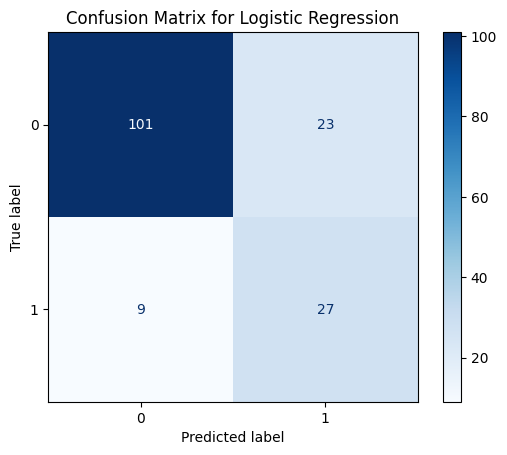

In [115]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix for Logistic Regression
y_pred = models[0].predict(X_val)
conf_matrix = metrics.confusion_matrix(Y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=models[0].classes_)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()